# CREATE A COPY FIRST!

# **Question 1: Fine-Tune EfficientNetV2-Medium for Bone Fracture Classification**

##### This dataset contains **X-ray images** of various types of bone fractures, categorized into **12 classes**.

##### Complete the tasks below to fine-tune a **pretrained EfficientNetV2-Medium** model on this dataset to classify bone fractures.

In [19]:
# # Please uncomment this out when you are running this lab on google colab!
import os

#Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shyamgupta196/bone-fracture-split-classification")

print("Path to dataset files:", path)

Path to dataset files: /content/data/datasets/shyamgupta196/bone-fracture-split-classification/versions/1


In [21]:
class_to_idx = {
    "Avulsion fracture": 0,
    "Comminuted fracture": 1,
    "Compression-Crush fracture": 2,
    "Fracture Dislocation": 3,
    "Greenstick fracture": 4,
    "Hairline Fracture": 5,
    "Impacted fracture": 6,
    "Intra-articular fracture": 7,
    "Longitudinal fracture": 8,
    "Oblique fracture": 9,
    "Pathological fracture": 10,
    "Spiral Fracture": 11
}

# TASK 1: Define the Dataset Class & Dataloader

### Note: You can build a custom dataset class or use any torch built-in dataset classes (e.g. TensorDataset, ImageFolder,...)

In [22]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dir = path + "/train"
test_dir = path + "/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

#print Dataset
print(f"Train Dataset: {len(train_dataset)} images")
print(f"Test Dataset: {len(test_dataset)} images")
print(f"Classes: {train_dataset.classes}")

#check DataLoader
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")


Train Dataset: 1171 images
Test Dataset: 515 images
Classes: ['Avulsion fracture', 'Comminuted fracture', 'Compression-Crush fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Intra-articular fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']
Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([ 1, 11,  1,  2,  3])


## TASK 2: Display some images from the dataset

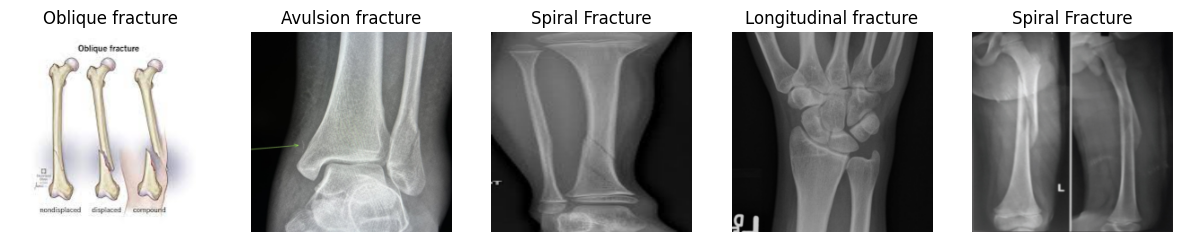

In [23]:
import matplotlib.pyplot as plt
def show_images(dataloader, classes):
    images, labels = next(iter(dataloader))  #get images
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))  #create a figure with 5 images
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(classes[labels[i].item()])  #display label
        ax.axis("off")
    plt.show()

#display from train dataset
show_images(train_loader, train_dataset.classes)


# TASK 3: Define the Model

### You should finetune EfficientNetV2 Medium. Can be imported as follows:

from torchvision.models import efficientnet_v2_m

In [24]:
import torch.nn as nn
import torchvision.models as models
model = models.efficientnet_v2_m(pretrained=True)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 12)  #making it 12 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

# TASK 4: Training and Validation Loops

In [25]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)

    return avg_loss, accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)

    return avg_loss, accuracy


# TASK 5: Running Training

## (Bonus Task: Reach 50% Accuracy in the validation set. You may want to tune the learning rate and number of epochs)

In [26]:
num_epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc >= 0.50: #######IT reached higher than 0,50 before but i didnt have time to run it again before submiting
        print("reached 50% now its : ", val_acc)
        break


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5, Train Loss: 2.3873, Train Acc: 0.1708, Val Loss: 2.2602, Val Acc: 0.2291


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/5, Train Loss: 1.7514, Train Acc: 0.4697, Val Loss: 1.9648, Val Acc: 0.4019


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/5, Train Loss: 1.0647, Train Acc: 0.6883, Val Loss: 1.8542, Val Acc: 0.4466


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/5, Train Loss: 0.6307, Train Acc: 0.8173, Val Loss: 1.9280, Val Acc: 0.4951


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/5, Train Loss: 0.4303, Train Acc: 0.8685, Val Loss: 2.1470, Val Acc: 0.4913


# TASK 6: Plot Loss & Accuracy

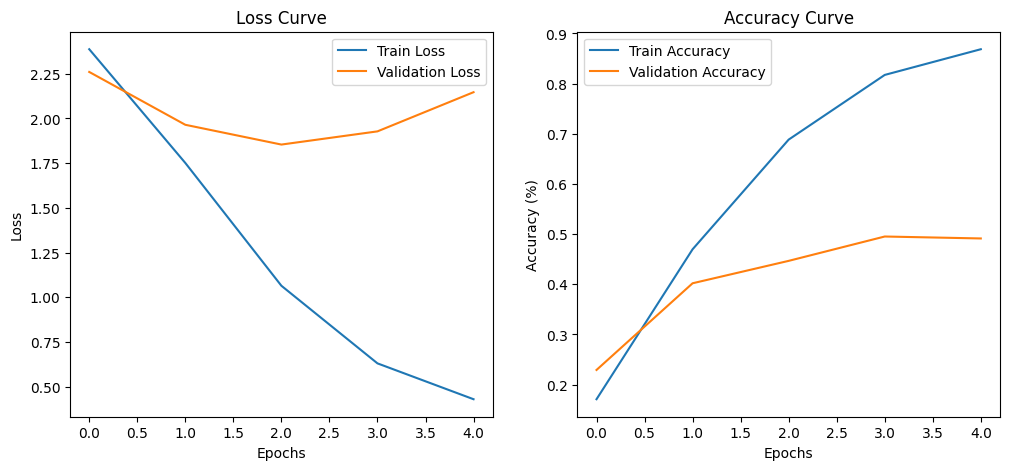

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


# BONUS Task: K-Fold Cross-Validation

Implement 5-fold cross-validation on the training dataset and print the accuracy scores for each fold by applying these steps:
- Use the `glob` module to collect image file paths from your training dataset.
- Create a pandas DataFrame that contains the file paths and corresponding labels.
- Implement `KFold` loop to split the DataFrame into training and validation folds.
- Inside the KFold loop, initialize your train and validation dataloaders, model and run the training.



In [ ]:
from sklearn.model_selection import KFold

# TO DO